In [1]:
# Import all of the python packages used in this workflow.
import numpy as np
from collections import OrderedDict
import os, sys
from pylab import *
import pandas as pd
import numpy as np
import osr
import xarray as xr
import geopandas as gpd
from datetime import datetime
from datetime import timedelta  
import json
import itertools
import requests
from sklearn.metrics import r2_score
import time
from xgrads import open_CtlDataset



########## USER ###########
# Select modeling domain
domain = 'BEAU'

# SM location 
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cal_cfsv2/'
# met forcing file name
metFname = 'cfsv2_mm_'+domain+'_cal_wy2012-2018.dat'

# location of SM forcing data
datapath = '/nfs/attic/dfh/2020_NPRB/data/SMinputs/'+domain+'/'
# Outfile path
outpath = '/nfs/attic/dfh/2020_NPRB/results/calibration/'+domain+'/prep_files/'

#path to CSO domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

#start calibration date    
st_dt = '2011-10-01'
#end calibration date
ed_dt = '2018-09-30'

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# Snotel projection
stn_proj = domains[domain]['stn_proj']
# model projection
mod_proj = domains[domain]['mod_proj']

# Import CSO gdf (metadata) and df (daily SWE data) 

In [2]:
gdf = gpd.read_file('/nfs/attic/dfh/2020_NPRB/data/snotel/'+domain+'/Station_sites_SWEDmeters_'+domain+'_'+st_dt+'_'+ed_dt+'.geojson')
path = '/nfs/attic/dfh/2020_NPRB/data/snotel/'+domain+'/Station_data_SWEDmeters_'+st_dt+'_'+ed_dt+'.csv'
df = pd.read_csv(path,parse_dates=True,index_col=0)
# # slice swe to calibration time period
# df = df[st_dt:ed_dt]

# Import prec correction factor

In [3]:
# # load prec cf df
cfdf = pd.read_csv(datapath + domain+'_precCF_'+st_dt+'_'+ed_dt+'_cfsv2.csv')
cfdf
# calculate weighted correction factor
cf = round(np.nansum(cfdf.cf*cfdf.wt),2)
cf

0.85

# Import computed lapse rates and format for calibration

In [5]:
# #open computed lapse files 
# lapse = pd.read_csv(datapath+domain+'_lapse_rates.csv',index_col=0)
# # make string of temperature lapse rates
# tlapse = '%2.2f'%(lapse.tlapse[0])+','+'%2.2f'%(lapse.tlapse[1])+','+'%2.2f'%(lapse.tlapse[2])+','+ '%2.2f'%(lapse.tlapse[3])+','+'%2.2f'%(lapse.tlapse[4])+','+'%2.2f'%(lapse.tlapse[5])+','+ '%2.2f'%(lapse.tlapse[6])+','+'%2.2f'%(lapse.tlapse[7])+','+'%2.2f'%(lapse.tlapse[8])+','+ '%2.2f'%(lapse.tlapse[9])+','+'%2.2f'%(lapse.tlapse[10])+','+'%2.2f'%(lapse.tlapse[11])
# # make string of precipitation lapse rates
# plapse = '%2.2f'%(lapse.plapse[0])+','+'%2.2f'%(lapse.plapse[1])+','+'%2.2f'%(lapse.plapse[2])+','+ '%2.2f'%(lapse.plapse[3])+','+'%2.2f'%(lapse.plapse[4])+','+'%2.2f'%(lapse.plapse[5])+','+ '%2.2f'%(lapse.plapse[6])+','+'%2.2f'%(lapse.plapse[7])+','+'%2.2f'%(lapse.plapse[8])+','+ '%2.2f'%(lapse.plapse[9])+','+'%2.2f'%(lapse.plapse[10])+','+'%2.2f'%(lapse.plapse[11])

# Import baseline .par parameters 

In [4]:
with open('/nfs/attic/dfh/2020_NPRB/data/json/par_base.json') as f:
    base = json.load(f)

base.keys()

dict_keys(['nx', 'ny', 'deltax', 'deltay', 'xmn', 'ymn', 'dt', 'iyear_init', 'imonth_init', 'iday_init', 'xhour_init', 'max_iter', 'isingle_stn_flag', 'igrads_metfile', 'met_input_fname', 'undef', 'ascii_topoveg', 'topoveg_grads_fname', 'topo_ascii_fname', 'veg_ascii_fname', 'ved_shd_25', 'ved_shd_26', 'ved_shd_27', 'ved_shd_28', 'ved_shd_29', 'ved_shd_30', 'const_veg_flag', 'iveg_ht_flag', 'xlat', 'lat_solar_flag', 'UTC_flag', 'run_micromet', 'run_enbal', 'run_snowpack', 'run_snowtran', 'irun_data_assim', 'ihrestart_flag', 'i_dataassim_loop', 'ihrestart_inc', 'i_tair_flag', 'i_rh_flag', 'i_wind_flag', 'i_solar_flag', 'i_longwave_flag', 'i_prec_flag', 'ifill', 'iobsint', 'dn', 'barnes_lg_domain', 'n_stns_used', 'snowmodel_line_flag', 'check_met_data', 'curve_len_scale', 'slopewt', 'curvewt', 'curve_lg_scale_flag', 'windspd_min', 'lapse_rate_user_flag', 'iprecip_lapse_rate_user_flag', 'iprecip_scheme', 'snowfall_frac', 'wind_lapse_rate', 'calc_subcanopy_met', 'gap_frac', 'cloud_frac_fac

# Function to edit text files 
## Edit snowmodel.par and snowmodel.inc to run SnowModel as line

In [5]:
#function to edit SnowModel Files other than .par
def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

# Functions to adjust calibration parameters
## Edit snowmodel.par to run SnowModel as line -> Dave's code

In [6]:
def edit_par(par_dict,parameter,new_value,parFile):
    lines = open(parFile, 'r').readlines()
    if par_dict[parameter][2] == 14 or par_dict[parameter][2] == 17 \
    or par_dict[parameter][2] == 18 or par_dict[parameter][2] == 19 \
    or par_dict[parameter][2] == 93 or par_dict[parameter][2] == 95 \
    or par_dict[parameter][2] == 97 or par_dict[parameter][2] == 100 \
    or par_dict[parameter][2] == 102 or par_dict[parameter][2] == 104 \
    or par_dict[parameter][2] == 107 or par_dict[parameter][2] == 108 \
    or par_dict[parameter][2] == 147 or par_dict[parameter][2] == 148 \
    or par_dict[parameter][2] == 149:
        text = str(new_value)+'\n'
    else:
        text = str(new_value)+'\t\t\t!'+par_dict[parameter][1]
    lines[par_dict[parameter][2]] = text
    out = open(parFile, 'w')
    out.writelines(lines)
    out.close()


In [7]:
parFile = SMpath+'snowmodel.par'
incFile = SMpath+'code/snowmodel.inc'
compileFile = SMpath+'code/compile_snowmodel.script'
ctlFile = SMpath+'ctl_files/wo_assim/swed.ctl'
micrometFile = SMpath+'code/micromet_code.f'
sweFile = SMpath+'outputs/wo_assim/swed.gdat'
codepath = SMpath+'code'
calpath = '/nfs/attic/dfh/2020_NPRB/notebooks/02_preprocess_python/'

In [8]:
#edit snowmodel.par to run SM as a line 
# spatial inputs
edit_par(base,'nx',np.shape(gdf)[0],parFile)
edit_par(base,'ny',1,parFile)
edit_par(base,'xmn',domains[domain]['xll'],parFile)
edit_par(base,'ymn',domains[domain]['yll'],parFile)
edit_par(base,'deltax',domains[domain]['cellsize'],parFile)
edit_par(base,'deltay',domains[domain]['cellsize'],parFile)
# temporal inputs
edit_par(base,'dt',21600,parFile) #seconds per model time step
edit_par(base,'iyear_init',datetime.strptime(st_dt,'%Y-%m-%d').year,parFile)
edit_par(base,'imonth_init',datetime.strptime(st_dt,'%Y-%m-%d').month,parFile)
edit_par(base,'iday_init',datetime.strptime(st_dt,'%Y-%m-%d').day,parFile)
edit_par(base,'xhour_init',datetime.strptime(st_dt,'%Y-%m-%d').hour,parFile)
max_iter = (datetime.strptime(ed_dt,'%Y-%m-%d')-datetime.strptime(st_dt,'%Y-%m-%d')).days*4+4
edit_par(base,'max_iter',max_iter,parFile)
# paths 
#edit_par(base,'met_input_fname','../../data/SMinputs/'+domain+'/'+metFname,parFile)
edit_par(base,'met_input_fname','../../data/SMinputs/'+domain+'/'+metFname,parFile)
edit_par(base,'ascii_topoveg',1,parFile)
edit_par(base,'topo_ascii_fname','../../data/SMinputs/'+domain+'/'+domain+'_dem_line.asc',parFile)
edit_par(base,'veg_ascii_fname','../../data/SMinputs/'+domain+'/'+domain+'_veg_line.asc',parFile)
edit_par(base,'lat_file_path','../../data/SMinputs/'+domain+'/'+domain+'_grid_lat_line.asc',parFile)
edit_par(base,'lon_file_path','../../data/SMinputs/'+domain+'/'+domain+'_grid_lon_line.asc',parFile)
edit_par(base,'snowmodel_line_file','../../data/SMinputs/'+domain+'/snowmodel_line_pts.dat',parFile)
edit_par(base,'output_path_wo_assim','outputs/wo_assim/',parFile)
#other flags to calibrate SM as line
edit_par(base,'xlat',round(domains[domain]['Bbox']['latmin']+(domains[domain]['Bbox']['latmax']-domains[domain]['Bbox']['latmin'])/2,2),parFile)
edit_par(base,'run_snowtran',0,parFile)
edit_par(base,'barnes_lg_domain',1,parFile)
edit_par(base,'lat_solar_flag',1,parFile)
edit_par(base,'snowmodel_line_flag',1,parFile)
edit_par(base,'print_inc',4,parFile)
edit_par(base,'print_var_01','n',parFile)#tair
edit_par(base,'print_var_09','n',parFile)#prec
edit_par(base,'print_var_10','n',parFile)#rain
edit_par(base,'print_var_11','n',parFile)#sprec
edit_par(base,'print_var_12','n',parFile)#swemelt
edit_par(base,'print_var_14','n',parFile)#runoff
edit_par(base,'print_var_18','y',parFile)#swed
edit_par(base,'cf_precip_flag',3,parFile)
edit_par(base,'UTC_flag',1,parFile)
edit_par(base,'n_stns_used',4,parFile)
edit_par(base,'check_met_data',0,parFile)
edit_par(base,'multilayer_snowpack',1,parFile)
edit_par(base,'max_layers',10,parFile)
edit_par(base,'lapse_rate_user_flag',1,parFile)
edit_par(base,'cf_precip_scalar',cf,parFile) 

##edit snowmodel.inc
replace_line(incFile, 12, '      parameter (nx_max='+str(np.shape(gdf)[0]+1)+',ny_max=2)\n')
replace_line(incFile, 18, '      parameter (max_time_steps='+str(max_iter+1)+')\n') 
replace_line(incFile, 41, '      parameter (nz_max=21)\n') 
#replace_line(incFile, 12, '      parameter (nx_max=1383,ny_max=2477)\n')#full domain


###edit compile_snowmodel.script
##replace_line(compileFile, 16, '#pgf77 -O3 -mcmodel=medium -I$path -o ../snowmodel $path$filename1 $path$filename2 $path$filename3 $path$filename4 $path$filename5 $path$filename6 $path$filename7 $path$filename8 $path$filename9 $path$filename10\n')
#replace_line(compileFile, 20, 'gfortran -O3 -mcmodel=medium -I$path -o ../snowmodel $path$filename1 $path$filename2 $path$filename3 $path$filename4 $path$filename5 $path$filename6 $path$filename7 $path$filename8 $path$filename9 $path$filename10\n')

In [9]:
pwd

'/nfs/attic/dfh/2020_NPRB/notebooksBEAU/01_calibrate_cfsv2'

# Function to compile and run SnowModel

In [10]:
#function to calibrate and run SM
st_time = time.time()
def runcalSnowModel():
    get_ipython().run_line_magic('cd', '$codepath')
    #run compile script 
    get_ipython().system(' ./compile_snowmodel.script')
    get_ipython().run_line_magic('cd', '$SMpath')
    get_ipython().system(' ./snowmodel')
runcalSnowModel()
get_ipython().run_line_magic('cd', '$calpath')
total_time = time.time()-st_time
print(total_time)

/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cal_cfsv2/code
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel2023_cal_cfsv2

 You are running the large-domain Barnes oi scheme
   This requires:
   1) no missing data for the fields of interest
   2) no missing stations during the simulation
   3) met file must list stations in the same order
   4) the number of nearest stations used is 9 or less
   5)  **** no error checking for this is done ****

 Generating nearest-station index.  Be patient.

                   WORKING ON MODEL TIME = 2011  10   1   0.0
                   WORKING ON MODEL TIME = 2011  10   1   6.0
                   WORKING ON MODEL TIME = 2011  10   1  12.0
                   WORKING ON MODEL TIME = 2011  10   1  18.0
                   WORKING ON MODEL TIME = 2011  10   2   0.0
                   WORKING ON MODEL TIME = 2011  10   2   6.0
                   WORKING ON MODEL TIME = 2011  10   2  12.0
                   WORKING ON MODEL TIME = 2011  10   2  18.0
 

##  need to check prec units on cmip6 data... it is a lot lower than cfsv2 

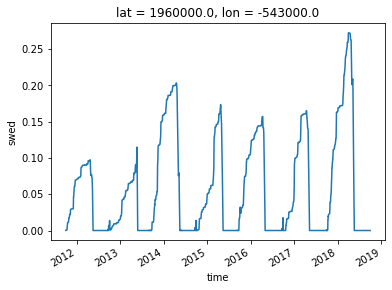

In [11]:
# from xgrads import open_CtlDataset
ctlFile = SMpath+'ctl_files/wo_assim/swed.ctl'

swe = open_CtlDataset(ctlFile)
swe.swed.plot()

In [12]:
def get_mod_dims():
    #get model data from .ctl file 
    f=open(ctlFile)
    lines=f.readlines()
    nx = int(lines[9].split()[1])
    xll = int(float(lines[9].split()[3]))
    clsz = int(float(lines[9].split()[4]))
    ny = int(lines[10].split()[1])
    yll = int(float(lines[10].split()[3]))
    num_sim_days = int(lines[14].split()[1])
    st = datetime.strptime(lines[14].split()[3][3:], '%d%b%Y').date()
    ed = st + timedelta(days=(num_sim_days-1))
    print('nx=',nx,'ny=',ny,'xll=',xll,'yll=',yll,'clsz=',clsz,'num_sim_days=',num_sim_days,'start',st,'end',ed)
    f.close()
    return nx, ny, xll, yll, clsz, num_sim_days, st, ed

nx, ny, xll, yll, clsz, num_sim_days, st, ed = get_mod_dims()

nx= 1 ny= 1 xll= -543000 yll= 1960000 clsz= 1000 num_sim_days= 2557 start 2011-10-01 end 2018-09-30


# Function to convert SnowModel output to numpy array

This function is to be used when running SnowModel as a line

In [13]:
## Build a function to convert the binary model output to numpy array

def get_mod_output_lines(inFile):
    #open the grads model output file, 'rb' indicates reading from binary file
    grads_data = open(inFile,'rb')
    # convert to a numpy array 
    numpy_data = np.fromfile(grads_data,dtype='float32',count=-1)
    #close grads file 
    grads_data.close()
    #reshape the data
    numpy_data = np.reshape(numpy_data,(num_sim_days,1,np.shape(gdf)[0]))
    #swe only at station point
    data = np.squeeze(numpy_data[:,0,:]) 

    return data

# Function for calculating performance statistics

In [14]:
#compute model performance metrics
def calc_metrics():
    swes = np.zeros((5,np.shape(gdf)[0]))
    
    for i in range(np.shape(gdf)[0]):
        mod_swes = get_mod_output_lines(sweFile)
        if mod_swes.ndim == 1:
            mod_swe = mod_swes
        else:
            mod_swe = mod_swes[:,i]
        loc = gdf['code'][i]
        stn_swe = df[loc].values
        
        #remove days with zero SWE at BOTH the station and the SM pixel
        idx = np.where((stn_swe != 0) & (mod_swe != 0))
        mod_swe = mod_swe[idx]
        stn_swe = stn_swe[idx]
        
        #remove days where station has nan values 
        idx = np.where(~np.isnan(stn_swe))
        mod_swe = mod_swe[idx]
        stn_swe = stn_swe[idx]
        
        #R-squared value
        swes[0,i] = r2_score(stn_swe, mod_swe)

        #mean bias error
        swes[1,i] = (sum(mod_swe - stn_swe))/mod_swe.shape[0]

        #root mean squared error
        swes[2,i] = np.sqrt((sum((mod_swe - stn_swe)**2))/mod_swe.shape[0])

        # Nash-Sutcliffe model efficiency coefficient, 1 = perfect, assumes normal data 
        nse_top = sum((mod_swe - stn_swe)**2)
        nse_bot = sum((stn_swe - np.mean(stn_swe))**2)
        swes[3,i] = (1-(nse_top/nse_bot))

        # Kling-Gupta Efficiency, 1 = perfect
        kge_std = (np.std(mod_swe)/np.std(stn_swe))
        kge_mean = (np.mean(mod_swe)/np.mean(stn_swe))
        kge_r = corrcoef(stn_swe,mod_swe)[1,0]
        swes[4,i] = (1 - (sqrt((kge_r-1)**2)+((kge_std-1)**2)+(kge_mean-1)**2))
        
    return swes

swe_stats = calc_metrics()

In [26]:
swe_stats

array([[0.56530867],
       [0.02602911],
       [0.04151392],
       [0.56530867],
       [0.76157985]])

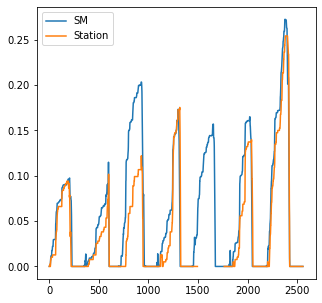

In [15]:
fig, axs = plt.subplots(figsize=(5, 5))
mod_swes = get_mod_output_lines(sweFile)
if mod_swes.ndim == 1:
    mod_swe = mod_swes
else:
    mod_swe = mod_swes[:,i]
loc = gdf['code'][0]
stn_swe = df[loc].values
axs.plot(mod_swe,label='SM')
axs.plot(stn_swe,label='Station')
plt.legend()

# Create dataframe of calibration parameters

In [24]:
#Calibration parameters

#snowfall_frac = [1,2,3]
#if = 1 -> 
#T_threshold = arange(float(base ['T_threshold'][0])-2,float(base ['T_threshold'][0])+2,1)
#if = 3 -> base['T_Left,T_Right']
#figure out how to parse these 

#snowfall_frac = [3]
#T_L_R = [base['T_Left,T_Right'][0],'-2,1','-2,2','-2,3','-1,1','-1,2','-1,3','0,2','0,3']

################# MultiLayer Snowpack ########################
max_layers = [1,10,20]
#print(max_layers, 'Max Layers')
#print(len(max_layers),'# of Values')

######################### Wind ###############################
# wind_lapse_rate = arange(float(base ['wind_lapse_rate'][0]),
#                  float(base ['wind_lapse_rate'][0])+2.5,.5)

######################### Solar ###############################

#lat_solar_flag = [0,1]

#################### Temperature ############################
lapse_rate= [base['lapse_rate'][0]]#,tlapse]

####################### Snow Density #######################
ro_snowmax=arange(float(base ['ro_snowmax'][0])-200,
                  float(base ['ro_snowmax'][0])+100,25)
ro_adjust=arange(float(base ['ro_adjust'][0])-3,
                 float(base ['ro_adjust'][0])+4,1)

#################### Precipitation ############################
# cf_precip_scalar=arange(float(base ['cf_precip_scalar'][0])-.4,
#                         float(base ['cf_precip_scalar'][0])+.4,.1)
# add cf_precip_flag = 3
prec_lapse_rate = [base ['prec_lapse_rate'][0]]#,plapse]

#################### Vegetation ############################
# CHUK station in shrub area, not forest, so these dont matter --> set to default
conifer_lai = [1.8]#arange(1.8,2.4,0.2)

gap_frac = [.2]#arange(0,1,.2)

Total_runs = len(max_layers) * len(lapse_rate) * len(gap_frac)* len(ro_snowmax)*len(ro_adjust)*len(prec_lapse_rate)*len(conifer_lai)
print('Total number of calibration runs = ',Total_runs)

# in the test model run -> get the wall time to estimate how long the calibration will take
wall_time = total_time
print('This will take approximately',Total_runs*wall_time/60/60,'hours')

Total number of calibration runs =  252
This will take approximately 3.998246901035309 hours


In [43]:
# Parameters used in this calibration run
parameters = [max_layers,lapse_rate,ro_snowmax,ro_adjust,gap_frac,prec_lapse_rate,conifer_lai]
data = list(itertools.product(*parameters))
input_params = pd.DataFrame(data,columns=['max_layers','lapse_rate','ro_snowmax','ro_adjust','gap_frac','prec_lapse_rate','conifer_lai'])


timestamp = str(datetime.date(datetime.now()))

#save input parameters as csv
input_params.to_csv(outpath+'cal_params_'+timestamp+'.csv',index=False)

# Run calibration

In [43]:
%%time
%cd $SMpath
top_swe = np.empty([len(input_params),num_sim_days,np.shape(gdf)[0]])
swe_stats = np.empty([shape(input_params)[0],5,np.shape(gdf)[0]])

if np.shape(gdf)[0] == 1:
    for i in range(np.shape(input_params)[0]):
        print(i+1, 'of', Total_runs)
        edit_par(base,'max_layers',input_params.max_layers[i],parFile)
        edit_par(base,'lapse_rate',input_params.lapse_rate[i],parFile)
        edit_par(base,'prec_lapse_rate',input_params.prec_lapse_rate[i],parFile)
        edit_par(base,'ro_snowmax',input_params.ro_snowmax[i],parFile)
        edit_par(base,'gap_frac',input_params.gap_frac[i],parFile)
        edit_par(base,'ro_adjust',input_params.ro_adjust[i],parFile)
        replace_line(micrometFile, 3347,'      data vlai_summer /'+str(input_params.conifer_lai[i])+', 2.5, 2.5, 1.5, 1.0/\n')
        replace_line(micrometFile, 3348,'      data vlai_winter /'+str(input_params.conifer_lai[i])+', 0.5, 1.5, 1.5, 1.0/\n')

        %cd $codepath        
        #run compile script       
        ! ./compile_snowmodel.script        
        %cd $SMpath
        ! nohup ./snowmodel      
        swe_stats[i,:,:] = calc_metrics()     
        mod_swe = get_mod_output_lines(sweFile)     
        top_swe[i,:,:] = mod_swe.reshape((len(mod_swe), 1))

else:
    for i in range(np.shape(input_params)[0]):
        print(i+1, 'of', Total_runs)
        edit_par(base,'max_layers',input_params.max_layers[i],parFile)
        edit_par(base,'lapse_rate',input_params.lapse_rate[i],parFile)
        edit_par(base,'prec_lapse_rate',input_params.prec_lapse_rate[i],parFile)
        edit_par(base,'ro_snowmax',input_params.ro_snowmax[i],parFile)
        edit_par(base,'gap_frac',input_params.gap_frac[i],parFile)
        edit_par(base,'ro_adjust',input_params.ro_adjust[i],parFile)
        replace_line(micrometFile, 3347,'      data vlai_summer /'+str(input_params.conifer_lai[i])+', 2.5, 2.5, 1.5, 1.0/\n')
        replace_line(micrometFile, 3348,'      data vlai_winter /'+str(input_params.conifer_lai[i])+', 0.5, 1.5, 1.5, 1.0/\n')
        %cd $codepath
        #run compile script
        ! ./compile_snowmodel.script
        %cd $SMpath
        ! nohup ./snowmodel
        swe_stats[i,:] = np.squeeze(calc_metrics())
        mod_swe = get_mod_output_lines(sweFile)
        top_swe[i,:] = mod_swe
%cd $calpath

/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel_calib
0
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel_calib/code
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel_calib
nohup: ignoring input and appending output to ‘nohup.out’
1
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel_calib/code
/nfs/attic/dfh/2020_NPRB/domain_BEAU/snowmodel_calib
nohup: ignoring input and appending output to ‘nohup.out’
/nfs/attic/dfh/2020_NPRB/notebooks/05_calibration_python
CPU times: user 349 ms, sys: 120 ms, total: 469 ms
Wall time: 1min 13s


# Save output as netcdf

In [ ]:
#Turn NDarray into xarray 
calibration_run = np.arange(0,swe_stats.shape[0],1)
metric = ['R2','MBE','RMSE','NSE','KGE']
station = gdf['code'].values

cailbration = xr.DataArray(
    swe_stats,
    dims=('calibration_run', 'metric', 'station'), 
    coords={'calibration_run': calibration_run, 
            'metric': metric, 'station': station})

cailbration.attrs['long_name']= 'Calibration performance metrics'
cailbration.attrs['standard_name']= 'cal_metrics'

d = OrderedDict()
d['calibration_run'] = ('calibration_run', calibration_run)
d['metric'] = ('metric', metric)
d['station'] = ('station', station)
d['cal_metrics'] = cailbration

ds = xr.Dataset(d)
ds.attrs['description'] = "SnowModel line calibration performance metrics"
ds.attrs['calibration_parameters'] = "ro_snowmax,cf_precip_scalar,ro_adjust"
ds.attrs['model_parameter'] = "SWE [m]"

ds.calibration_run.attrs['standard_name'] = "calibration_run"
ds.calibration_run.attrs['axis'] = "N"

ds.metric.attrs['long_name'] = "calibration_metric"
ds.metric.attrs['axis'] = "metric"

ds.station.attrs['long_name'] = "station_id"
ds.station.attrs['axis'] = "station"

ds.to_netcdf(outpath+'calibration_'+timestamp+'.nc', format='NETCDF4', engine='netcdf4')


In [ ]:
calibration_run = np.arange(0,top_swe.shape[0],1)
sim_day = np.arange(0,top_swe.shape[1],1)
station = gdf['code'].values

swe = xr.DataArray(
    top_swe,
    dims=('calibration_run', 'sim_day', 'station'), 
    coords={'calibration_run': calibration_run, 
            'sim_day': sim_day, 'station': station})

swe.attrs['long_name']= 'swe timeseries [m]'
swe.attrs['standard_name']= 'swe'

d = OrderedDict()
d['calibration_run'] = ('calibration_run', calibration_run)
d['sim_day'] = ('sim_day', sim_day)
d['station'] = ('station', station)
d['cal_metrics'] = swe

ds = xr.Dataset(d)
ds.attrs['description'] = "SnowModel swe"
ds.attrs['model_parameter'] = "SWE [m]"

ds.calibration_run.attrs['standard_name'] = "calibration_run"
ds.calibration_run.attrs['axis'] = "N"

ds.sim_day.attrs['long_name'] = "sumilation_day"
ds.sim_day.attrs['axis'] = "sim_day"

ds.station.attrs['long_name'] = "station_id"
ds.station.attrs['axis'] = "station"

ds.to_netcdf(outpath+'swe_'+timestamp+'.nc', format='NETCDF4', engine='netcdf4')